# Import Necessary Libraries

In [72]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from tqdm import tqdm



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

# Load Dataset

In [74]:
normal = pd.read_csv('data/ptbdb_normal.csv', header=None)
abnormal = pd.read_csv('data/ptbdb_abnormal.csv', header=None)
df = pd.concat([normal, abnormal], ignore_index=True)
df = shuffle(df).reset_index(drop=True)

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Data Preparation

In [76]:


column_names = [f'feature_{i}' for i in range(1, df.shape[1])] 
column_names.append('target') 

df.columns = column_names

print(df.head())
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
seed = 42
# Split training data into train and validation sets (80-20 split)
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=seed, stratify=y_train
)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sub)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to torch tensors and add channel dimension
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train_sub.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0   1.000000   0.842717   0.475481   0.241191   0.052670   0.064293   
1   1.000000   0.741746   0.323835   0.077793   0.148801   0.245138   
2   0.958428   0.813681   0.000000   0.084278   0.331066   0.498866   
3   1.000000   0.770316   0.538922   0.428571   0.288281   0.210009   
4   0.983766   0.992695   0.818994   0.720779   0.619318   0.530844   

   feature_7  feature_8  feature_9  feature_10  ...  feature_179  feature_180  \
0   0.120959   0.132946   0.134036    0.131493  ...          0.0          0.0   
1   0.239258   0.251470   0.230665    0.245138  ...          0.0          0.0   
2   0.509448   0.489040   0.487906    0.520786  ...          0.0          0.0   
3   0.179213   0.151839   0.136014    0.135158  ...          0.0          0.0   
4   0.407468   0.360390   0.284903    0.272727  ...          0.0          0.0   

   feature_181  feature_182  feature_183  feature_184  feature_185  \
0          0.0  

# Define CNN Model

In [78]:
#define plot structure
def plot_losses(train_losses, test_losses):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validating Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [79]:

class CNN_v2(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN_v2, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(2)

        self.dropout = nn.Dropout(0.5)
        self.global_pool = nn.AdaptiveMaxPool1d(1)

        self.fc1 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Initialize Model, Loss, Optimizer, Scheduler

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_v2(num_classes=2).to(device)

num_epochs = 100
learning_rate= 1e-4
weight_decay=1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_losses = []
val_losses = []

# Early Stopping Class

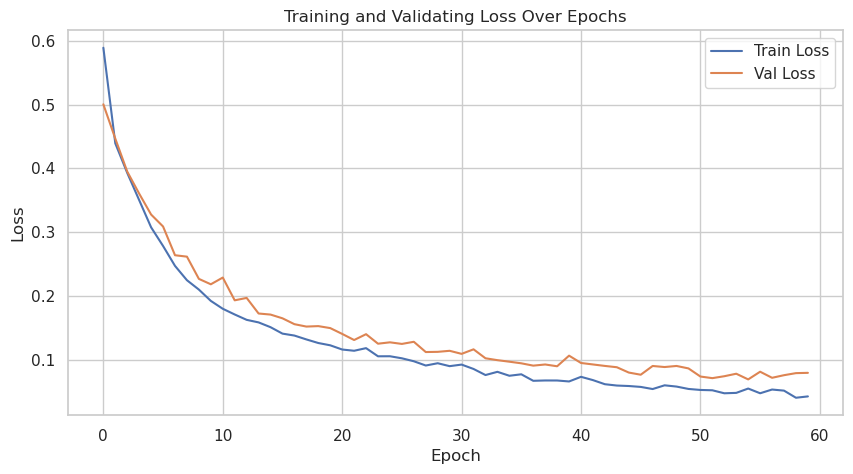

In [83]:
from IPython.display import clear_output
best_val_loss = float('inf')
patience = 5              # stop when there are 5 steps no imporvement
min_delta = 1e-4          # define imporvement is greater than 1e-4
counter = 0               
best_model_state = None   # save the best_model_state

# training
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}")
    
    plot_losses(train_losses, val_losses)

    # Early stopping check
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            break

# Restore best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)


# Load Best Model and Evaluate on Test Set

In [85]:
from sklearn.metrics import classification_report

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(batch_y.numpy())


print(model)
print(classification_report(y_true, y_pred, digits=3))

CNN_v2(
  (conv1): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (global_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)
              precisi

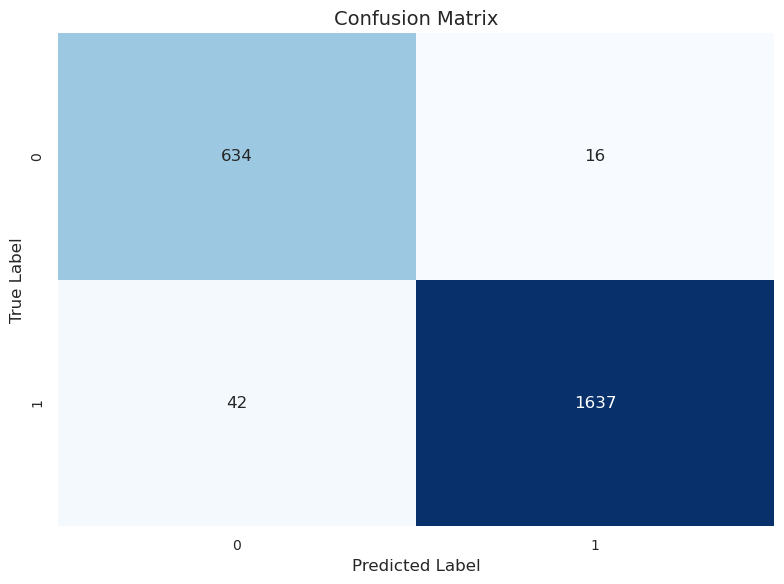

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [96]:
torch.save(model.state_dict(), 'cnn_model_v2.pkl')